### Import Libraries

In [1]:
import os # operating system
import re # regular expression

import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

import matplotlib.pyplot as plt
import seaborn as sns

### Get Data from Kaggle

In [2]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won"t be saved outside of the current session

data_dir = "/kaggle/input/march-machine-learning-mania-2023/"

for file in sorted(os.listdir(data_dir)):
    print(file)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv



### Goal of the Competition
Another year, another chance to predict the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. In our ninth annual March Machine Learning Mania competition, Kagglers will once again join the millions of fans who attempt to predict the outcomes of this year"s college basketball tournaments. Unlike most fans, you will pick the winners and losers using a combination of rich historical data and computing power, while the ground truth unfolds on television.


### Context
You are provided data of historical NCAA games to forecast the outcomes of the Division 1 Men"s and Women"s basketball tournaments. This competition is the official 2023 edition, with points, medals, prizes, and basketball glory at stake.

We have made several updates to the competition format compared to prior editions:

1. There is a change in evaluation metric from log loss to Brier scores. See the Evaluation Page for full details.
2. We are combining the Men"s and Women"s tournament into one single competition, instead of running separate tracks. The competition will award full points/medals as a result.
3. We have changed the prediction format so that you may forecast the 2023 tournaments right away, instead of having to wait to see which teams are selected for the tournament.

We have also launched a companion warmup competition, which is setup as a practice leaderboard covering the previous five tournaments. Because its only for practice and the ground historical game outcomes are public information, the warmup competition does not count for points/medals and will be taken down once it has served its purpose. Prior to the start of the tournaments, the leaderboard of this competition will reflect all zero scores. Kaggle will periodically fill in the outcomes and rescore once games begin.

Good luck and happy forecasting!

### Dataset Description
Each season there are thousands of NCAA basketball games played between Division I college basketball teams, culminating in March Madness®, the 68-team national championship that starts in the middle of March. We have provided a large amount of historical data about college basketball games and teams, going back many years. Armed with this historical data, you can explore it and develop your own distinctive ways of predicting March Madness® game outcomes. You can even evaluate and compare different approaches by seeing which of them would have done best at predicting tournament games from the past.

If you are unfamiliar with the format and intricacies of the NCAA® tournament, we encourage reading the wikipedia pages for the men"s and women"s tournaments before before diving into the data.  The data description and schema may seem daunting at first, but is not as complicated as it appears.

Please note that in previous years, there were separate competitions for predicting the men"s tournament games or the women"s tournament games. In this year"s competition, you will be submitting combined prediction files that include predictions for both the men"s tournament and the women"s tournament. Thus the data files incorporate both men"s data and women"s data. The files that pertain only to men"s data will start with the letter prefix M, and the files that pertain only to women"s data will start with the letter prefix W. Some files span both men"s and women"s data, such as Cities and Conferences, and these files do not start with an M prefix or a W prefix.

As a reminder, you are encouraged to incorporate your own sources of data. We have provided extensive historical data to jump-start the modeling process, and this data is self-consistent (for instance, dates and team ID"s are always treated the same way). Nevertheless, you may also be able to make productive use of external data. If you head down this path, please be forewarned that many sources have their own distinctive way of identifying the names of teams, and this can make it challenging to link up with our data. The MTeamSpellings and WTeamSpellings files, which are listed in the bottom section below, may help you map external team references into our own Team ID structure, and you may also need to understand exactly how dates work in our data.

### What to Predict 
~~Warmup Competition - You should submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (2017-2019 and 2021-2022). Note that there was no tournament held in 2020.~~

**2023 Competition - You should submit predicted probabilities for every possible matchup before the 2023 tournament begins.**

### Load and Prepare Data
Load and combine data for analysis.

#### MNCAATourneySeeds.csv & WNCAATourneySeeds.csv

These files identify the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday/Friday of the first week (by definition, that is DayNum=136/137 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 12, 2023 (DayNum=132).

* **Season** - the year that the tournament was played in
* **Seed** - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have seeds with the same first three characters. The "a" and "b" are assigned based on which Team ID is lower numerically. As an example of the format of the seed, the first record in the MNCAATourneySeeds file is seed W01 from 1985, which means we are looking at the #1 seed in the W region (which we can see from the "MSeasons.csv" file was the East region).
* **TeamID** - this identifies the id number of the team, as specified in the MTeams.csv or WTeams.csv file

Create function to concat dataframes to reduce redundancy:

In [3]:
def concat_dfs(dfs, data_dir="/kaggle/input/march-machine-learning-mania-2023/"):
    """Returns a concatenated dataframe from a list of dataframe basenames in the data_dir.
    
    Args:
        dfs - list: list of dataframe basenames to concatenate together
        data_dir - str: directory of dataframe basenames
        
    Returns:
        df_concat - object: concatenated dataframe
    """
    dfs_to_concat = []
    for df in dfs:
        if type(df) == str:
            df_path = os.path.join(data_dir, df)
            df = pd.read_csv(df_path)
        dfs_to_concat.append(df)
    df_concat = pd.concat(dfs_to_concat)
    return df_concat

Concatenate and check dataframe for men"s and women"s tournament seeding. 

In [4]:
dfs = ["MNCAATourneySeeds.csv", "WNCAATourneySeeds.csv"]

df_tourney_seeds = concat_dfs(dfs)

df_tourney_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Check for missing values:

In [5]:
df_tourney_seeds.isnull().sum()

Season    0
Seed      0
TeamID    0
dtype: int64

Check for duplicated values:

In [6]:
df_tourney_seeds.duplicated().sum()

0

#### MRegularSeasonCompactResults.csv & WRegularSeasonCompactResults.csv

These files identify the game-by-game results for many seasons of historical data, starting with the 1985 season for men (the first year the NCAA® had a 64-team men"s tournament) and the 1998 season for women. For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

* **Season** - this is the year of the associated entry in MSeasons.csv or WSeasons.csv, namely the year in which the final tournament occurs. For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.
* **DayNum** - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "MSeasons.csv" or "WSeasons.csv" file. For example, the first game in the "MRegularSeasonCompactResults.csv" file was DayNum=20. Combined with the fact from the "MSeasons.csv" file that day zero was 10/29/1984 that year, this means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID). In order to accomplish this uniqueness, we had to adjust one game"s date. In March 2008, the men"s SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day because of a tornado, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original scheduled date.
* **WTeamID** - this identifies the id number of the team that won the game, as listed in the "MTeams.csv" or "WTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team. Please note that in this case the "W" in "WTeamID does not refer to women"s data; the "W" is for "winning". Both the men"s data and women"s data will identify the winning team id by this WTeamID column. The same note applies to WScore and WLoc below - these are "W" for "winning" and not for "women"s".
* **WScore** - this identifies the number of points scored by the winning team.
* **LTeamID** - this identifies the id number of the team that lost the game.
* **LScore** - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.
* **WLoc** - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting (or "away") team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team"s home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.
* **NumOT** - this indicates the number of overtime periods in the game, an integer 0 or higher.

Concat men"s and women"s dataframes:

In [7]:
dfs = ["MRegularSeasonCompactResults.csv", "WRegularSeasonCompactResults.csv"]

df_regular_season_results = concat_dfs(dfs)

df_regular_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


```NumOT``` & ```WLoc``` doesn"t seem important for predicting outcomes of games given we are not predicting with knowledge of the home court advantage. Drop them:

In [8]:
df_regular_season_results = df_regular_season_results.drop(columns=["NumOT", "WLoc"])

df_regular_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,20,1228,81,1328,64
1,1985,25,1106,77,1354,70
2,1985,25,1112,63,1223,56
3,1985,25,1165,70,1432,54
4,1985,25,1192,86,1447,74


#### Create additional features

**Point differential (winning team"s score - losing team"s score)** is an important metric that measures the strength of the winning team; strong teams not only win, but win big. Create a new point differential feature on the ```df_regular_season_results``` dataframe:

In [9]:
df_regular_season_results["PointDiff"] = df_regular_season_results["WScore"] - df_regular_season_results["LScore"]

df_regular_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,PointDiff
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


Check for missing values:

In [10]:
df_regular_season_results.isnull().sum()

Season       0
DayNum       0
WTeamID      0
WScore       0
LTeamID      0
LScore       0
PointDiff    0
dtype: int64

Check for duplicated values:

In [11]:
df_regular_season_results.duplicated().sum()

0

**Total number of wins per season for each team:**

In [12]:
total_wins = df_regular_season_results.groupby(["Season", "WTeamID"]).count()
total_wins = total_wins.reset_index()[["Season", "WTeamID", "DayNum"]].rename(columns={"DayNum": "TotalWins", "WTeamID": "TeamID"})

total_wins.head()

,Season,TeamID,TotalWins
0,1985,1102,5
1,1985,1103,9
2,1985,1104,21
3,1985,1106,10
4,1985,1108,19


**Total number of losses per season for each team:**

In [13]:
total_losses = df_regular_season_results.groupby(["Season", "LTeamID"]).count()
total_losses = total_losses.reset_index()[["Season", "LTeamID", "DayNum"]].rename(columns={"DayNum": "TotalLosses", "LTeamID": "TeamID"})

total_losses.head()

,Season,TeamID,TotalLosses
0,1985,1102,19
1,1985,1103,14
2,1985,1104,9
3,1985,1106,14
4,1985,1108,6


**Median Win Point Differential:**

In [14]:
median_win_point_diff = df_regular_season_results.groupby(["Season", "WTeamID"]).median() # median instead of mean to better filter outliers
median_win_point_diff = median_win_point_diff.reset_index()[["Season", "WTeamID", "PointDiff"]].rename(columns={"WTeamID" : "TeamID", "PointDiff" : "WinPointsDiff"})

median_win_point_diff.head()

,Season,TeamID,WinPointsDiff
0,1985,1102,4.0
1,1985,1103,7.0
2,1985,1104,13.0
3,1985,1106,5.5
4,1985,1108,14.0


**Median Loss Point Differential:**

In [15]:
median_loss_point_diff = df_regular_season_results.groupby(["Season", "LTeamID"]).median() # median instead of mean to better filter outliers
median_loss_point_diff = median_loss_point_diff.reset_index()[["Season", "LTeamID", "PointDiff"]].rename(columns={"LTeamID" : "TeamID", "PointDiff" : "LossPointsDiff"})

median_loss_point_diff.head()

,Season,TeamID,LossPointsDiff
0,1985,1102,9.0
1,1985,1103,9.5
2,1985,1104,4.0
3,1985,1106,10.5
4,1985,1108,12.5


Merge new features into one dataframe:

In [16]:
df_regular_season_w = df_regular_season_results.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID"]].rename(columns={"WTeamID": "TeamID"})
df_regular_season_l = df_regular_season_results.groupby(["Season", "LTeamID"]).count().reset_index()[["Season", "LTeamID"]].rename(columns={"LTeamID": "TeamID"})

dfs = [df_regular_season_w, df_regular_season_l]

df_regular_season_merged = concat_dfs(dfs).drop_duplicates().sort_values(["Season", "TeamID"]).reset_index(drop=True)

dfs_to_merge = [median_loss_point_diff, median_win_point_diff, total_losses, total_wins]
merge_on = ["Season", "TeamID"]

for df_to_merge in dfs_to_merge:
    df_regular_season_merged = df_regular_season_merged.merge(df_to_merge, on=merge_on)
    
df_regular_season_merged.head()

,Season,TeamID,LossPointsDiff,WinPointsDiff,TotalLosses,TotalWins
0,1985,1102,9.0,4.0,19,5
1,1985,1103,9.5,7.0,14,9
2,1985,1104,4.0,13.0,9,21
3,1985,1106,10.5,5.5,14,10
4,1985,1108,12.5,14.0,6,19


#### Create additional summary features:

**Win Rate (```TotalWins``` / Total oppurtunities for wins)**

In [17]:
df_regular_season_merged["WinRate"] = df_regular_season_merged["TotalWins"] / ((df_regular_season_merged["TotalWins"] + df_regular_season_merged["TotalLosses"]))

df_regular_season_merged.head()

,Season,TeamID,LossPointsDiff,WinPointsDiff,TotalLosses,TotalWins,WinRate
0,1985,1102,9.0,4.0,19,5,0.208333
1,1985,1103,9.5,7.0,14,9,0.391304
2,1985,1104,4.0,13.0,9,21,0.700000
3,1985,1106,10.5,5.5,14,10,0.416667
4,1985,1108,12.5,14.0,6,19,0.760000


Drop ```TotalWins``` & ```TotalLosses``` since ```WinRate``` captures both of these:

In [18]:
df_regular_season_merged = df_regular_season_merged.drop(columns=["TotalWins", "TotalLosses"])

df_regular_season_merged.head()

,Season,TeamID,LossPointsDiff,WinPointsDiff,WinRate
0,1985,1102,9.0,4.0,0.208333
1,1985,1103,9.5,7.0,0.391304
2,1985,1104,4.0,13.0,0.700000
3,1985,1106,10.5,5.5,0.416667
4,1985,1108,12.5,14.0,0.760000


Check for missing values:

In [19]:
df_regular_season_merged.isnull().sum()

Season            0
TeamID            0
LossPointsDiff    0
WinPointsDiff     0
WinRate           0
dtype: int64

Check for duplicated values:

In [20]:
df_regular_season_merged.duplicated().sum()

0

#### MNCAATourneyCompactResults.csv and WNCAATourneyCompactResults.csv

These files identify the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the corresponding RegularSeasonCompactResults data. All men"s games will show up as neutral site (so WLoc is always N) and some women"s games will show up as neutral site, depending on the specifics. Note that this tournament game data also includes the play-in games for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

Because of the consistent structure of the NCAA® tournament schedule, you can generally tell what round a game was, depending on the exact DayNum. However, the men"s 2021 tournament scheduling was slightly different, and the women"s scheduling has varied a lot. Nevertheless, in general the men"s schedule will be:

* **DayNum=134 or 135 (Tue/Wed)** - play-in games to get the tournament field down to the final 64 teams
* **DayNum=136 or 137 (Thu/Fri)** - Round 1, to bring the tournament field from 64 teams to 32 teams
* **DayNum=138 or 139 (Sat/Sun)** - Round 2, to bring the tournament field from 32 teams to 16 teams
* **DayNum=143 or 144 (Thu/Fri)** - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams
* **DayNum=145 or 146 (Sat/Sun)** - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams
* **DayNum=152 (Sat)** - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams
* **DayNum=154 (Mon)** - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

Special note: Each year, there are also going to be other games that happened after Selection Sunday, which are not part of the NCAA® Tournament. This includes tournaments like the postseason NIT, the CBI, the CIT, and the Vegas 16. Such games are not listed in the Regular Season or the NCAA® Tourney files; they can be found in the "Secondary Tourney" data files (only for men"s data) within Data Section 6. Although they would not be games you would ever be predicting directly for the NCAA® tournament, and they would not be games you would have data from at the time of predicting NCAA® tournament outcomes, you may nevertheless wish to make use of these games for model optimization, depending on your methodology. The more games that you can test your predictions against, the better your optimized model might eventually become, depending on how applicable all those games are. A similar argument might be advanced in favor of optimizing your predictions against conference tournament games, which might be viewed as reasonable proxies for NCAA® tournament games.



In [21]:
dfs = ["MNCAATourneyCompactResults.csv", "WNCAATourneyCompactResults.csv"]

df_compact_results_concat = concat_dfs(dfs)

df_compact_results_concat.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Like previous dataframes, drop ```WLoc``` & ```NumOT```:

In [22]:
df_compact_results_concat = df_compact_results_concat.drop(columns=["WLoc", "NumOT"])

df_compact_results_concat.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


Merge winning seeds with compact results:

In [23]:
df = pd.merge(
    df_compact_results_concat, 
    df_tourney_seeds, 
    how="left", 
    left_on=["Season", "WTeamID"], 
    right_on=["Season", "TeamID"]
).drop(columns="TeamID").rename(columns={"Seed": "SeedW"})

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW
0,1985,136,1116,63,1234,54,X09
1,1985,136,1120,59,1345,58,Z11
2,1985,136,1207,68,1250,43,W01
3,1985,136,1229,58,1425,55,Y09
4,1985,136,1242,49,1325,38,Z03


Merge losing seeds with compact results:

In [24]:
df = pd.merge(
    df, 
    df_tourney_seeds, 
    how="left", 
    left_on=["Season", "LTeamID"], 
    right_on=["Season", "TeamID"]
).drop(columns="TeamID").rename(columns={"Seed": "SeedL"})

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,1985,136,1116,63,1234,54,X09,X08
1,1985,136,1120,59,1345,58,Z11,Z06
2,1985,136,1207,68,1250,43,W01,W16
3,1985,136,1229,58,1425,55,Y09,Y08
4,1985,136,1242,49,1325,38,Z03,Z14


```SeedL``` & ```SeedW``` look like the wrong format (str). Create a function to reformat these:

In [25]:
def format_seeds(seed):
    """Reformats seeds from strings to correct integer placements.
    
    Args:
        seed - str: seed with a character followed by two numbers - A21.
        
    Returns:
        formatted_seed - int: formatted seed to an int.
    """
    formatted_seed = int(re.sub("[^0-9]", "", seed))
    return formatted_seed

Reformat ```SeedL``` & ```SeedW```:

In [26]:
df["SeedL"] = df["SeedL"].apply(format_seeds)
df["SeedW"] = df["SeedW"].apply(format_seeds)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,1985,136,1116,63,1234,54,9,8
1,1985,136,1120,59,1345,58,11,6
2,1985,136,1207,68,1250,43,1,16
3,1985,136,1229,58,1425,55,9,8
4,1985,136,1242,49,1325,38,3,14


Merge ```df_merge``` with the extracted features from the Regular Season Compact data:

Losing TeamIDs:

In [27]:
df = pd.merge(
    df, 
    df_regular_season_merged, 
    how="left", 
    left_on=["Season", "LTeamID"], 
    right_on=["Season", "TeamID"]
).rename(columns={"LossPointsDiff" : "LossPointsDiffL",
                  "WinPointsDiff" : "WinPointsDiffL",
                  "WinRate" : "WinRateL"}
).drop(columns="TeamID")

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,LossPointsDiffL,WinPointsDiffL,WinRateL
0,1985,136,1116,63,1234,54,9,8,4.0,14.0,0.666667
1,1985,136,1120,59,1345,58,11,6,11.5,10.0,0.680000
2,1985,136,1207,68,1250,43,1,16,6.0,4.0,0.379310
3,1985,136,1229,58,1425,55,9,8,5.0,7.0,0.678571
4,1985,136,1242,49,1325,38,3,14,7.0,8.0,0.740741


Winning TeamIDs:

In [28]:
df = pd.merge(
    df, 
    df_regular_season_merged, 
    how="left", 
    left_on=["Season", "WTeamID"], 
    right_on=["Season", "TeamID"]
).rename(columns={"LossPointsDiff" : "LossPointsDiffW",
                  "WinPointsDiff" : "WinPointsDiffW",
                  "WinRate" : "WinRateW"}
).drop(columns="TeamID")

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,LossPointsDiffL,WinPointsDiffL,WinRateL,LossPointsDiffW,WinPointsDiffW,WinRateW
0,1985,136,1116,63,1234,54,9,8,4.0,14.0,0.666667,4.0,8.0,0.636364
1,1985,136,1120,59,1345,58,11,6,11.5,10.0,0.680000,7.0,7.0,0.620690
2,1985,136,1207,68,1250,43,1,16,6.0,4.0,0.379310,1.5,16.0,0.925926
3,1985,136,1229,58,1425,55,9,8,5.0,7.0,0.678571,10.0,10.0,0.740741
4,1985,136,1242,49,1325,38,3,14,7.0,8.0,0.740741,7.0,9.0,0.766667


Seed difference may predict the outcome of a game. It may be likely on average for higher seeds to beat lower seeds. Create ```SeedDiff``` feature for both teams:

In [29]:
df["SeedDiff"] = df["SeedW"] - df["SeedL"]

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,LossPointsDiffL,WinPointsDiffL,WinRateL,LossPointsDiffW,WinPointsDiffW,WinRateW,SeedDiff
0,1985,136,1116,63,1234,54,9,8,4.0,14.0,0.666667,4.0,8.0,0.636364,1
1,1985,136,1120,59,1345,58,11,6,11.5,10.0,0.680000,7.0,7.0,0.620690,5
2,1985,136,1207,68,1250,43,1,16,6.0,4.0,0.379310,1.5,16.0,0.925926,-15
3,1985,136,1229,58,1425,55,9,8,5.0,7.0,0.678571,10.0,10.0,0.740741,1
4,1985,136,1242,49,1325,38,3,14,7.0,8.0,0.740741,7.0,9.0,0.766667,-11


The data is only made from losing matches, add losing matches:

In [30]:
def add_losing(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({char : char[:-1] + "A" for char in df.columns if char.endswith("W")})
    win_rename.update({char : char[:-1] + "B" for char in df.columns if char.endswith("L")})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({char : char[:-1] + "B" for char in df.columns if char.endswith("W")})
    lose_rename.update({char : char[:-1] + "A" for char in df.columns if char.endswith("L")})
    
    df_win = df.copy()
    df_lose = df.copy()
    
    df_win = df_win.rename(columns=win_rename)
    df_lose = df_lose.rename(columns=lose_rename)
    
    return pd.concat([df_win, df_lose], axis=0, sort=False)

df = add_losing(df)

In [31]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,LossPointsDiffB,WinPointsDiffB,WinRateB,LossPointsDiffA,WinPointsDiffA,WinRateA,SeedDiff
0,1985,136,1116,63,1234,54,9,8,4.0,14.0,0.666667,4.0,8.0,0.636364,1
1,1985,136,1120,59,1345,58,11,6,11.5,10.0,0.680000,7.0,7.0,0.620690,5
2,1985,136,1207,68,1250,43,1,16,6.0,4.0,0.379310,1.5,16.0,0.925926,-15
3,1985,136,1229,58,1425,55,9,8,5.0,7.0,0.678571,10.0,10.0,0.740741,1
4,1985,136,1242,49,1325,38,3,14,7.0,8.0,0.740741,7.0,9.0,0.766667,-11


### Test Data
Prepare test data for submission format:

The evaluation methodology for 2023 has changed from prior editions of this competition. Submissions are now evaluated on the Brier score between the predicted probabilities and the actual game outcomes (this is equivalent to mean squared error in this context). This change was made to reduce the competitive "distractions" caused by the 0 and 1 boundaries of the previous log-loss metric (e.g. submitting rounded predictions to gamble on a given upset, or caring deeply about the 0.99 vs 0.999 distinction that log loss would reward/punish).

#### Submission File
The submission file format also has a revised format for 2023:

We have combined the Men"s and Women"s tournaments into one single competition. Your submission file should contain predictions for both.
You will now be predicting the hypothetical results for every possible team matchup, not just teams that are selected for the NCAA tournament. This change was enacted to provide a longer time window to submit predictions for the 2023 tournament. Previously, the short time between Selection Sunday and the tournament tipoffs would require participants to quickly turn around updated predictions. By forecasting every possible outcome between every team, you can now submit a valid prediction at any point leading up to the tournaments.
You may submit as many times as you wish before the tournaments start, but make sure to select the two submissions you want to count towards scoring. Do not rely on automatic selection to pick your submissions, as there is no public leaderboard score and the system will select your earliest two submissions.

As with prior years, each game has a unique ```ID``` created by concatenating the season in which the game was played and the two team"s respective ```TeamIds```. For example, "2023_1101_1102" indicates a hypothetical matchup between team 1101 and 1102 in the year 2023. You must predict the probability that the team with the lower ```TeamId``` beats the team with the higher ```TeamId```. Note that the men"s teams and women"s ```TeamIds``` do not overlap.

The resulting submission format looks like the following, where ```Pred``` represents the predicted probability that the first team will win:

ID,Pred
2023_1101_1102,0.5
2023_1101_1103,0.5
2023_1101_1104,0.5
...

Your 2023 submissions will score 0.0 if you have submitted predictions in the right format. The leaderboard of this competition will be only meaningful once the 2023 tournaments begin and Kaggle rescores your predictions!

In [32]:
df_test = pd.read_csv(data_dir + "SampleSubmission2023.csv")
df_test["Season"] = df_test["ID"].apply(lambda x: int(x.split("_")[0]))
df_test["TeamIdA"] = df_test["ID"].apply(lambda x: int(x.split("_")[1]))
df_test["TeamIdB"] = df_test["ID"].apply(lambda x: int(x.split("_")[2]))

df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


Add features:

In [33]:
df_test = pd.merge(
    df_test,
    df_tourney_seeds,
    how="left",
    left_on=["Season", "TeamIdA"],
    right_on=["Season", "TeamID"]
).drop(columns="TeamID").rename(columns={"Seed": "SeedA"}).fillna("W01")

df_test = pd.merge(
    df_test, 
    df_tourney_seeds, 
    how="left", 
    left_on=["Season", "TeamIdB"], 
    right_on=["Season", "TeamID"]
).drop(columns="TeamID").rename(columns={"Seed": "SeedB"}).fillna("W01")
df_test["SeedA"] = df_test["SeedA"].apply(format_seeds)
df_test["SeedB"] = df_test["SeedB"].apply(format_seeds)

df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,1,1
1,2023_1101_1103,0.5,2023,1101,1103,1,1
2,2023_1101_1104,0.5,2023,1101,1104,1,1
3,2023_1101_1105,0.5,2023,1101,1105,1,1
4,2023_1101_1106,0.5,2023,1101,1106,1,1


In [34]:
df_test = pd.merge(
    df_test, 
    df_regular_season_merged, 
    how="left", 
    left_on=["Season", "TeamIdA"], 
    right_on=["Season", "TeamID"]
).rename(columns={"LossPointsDiff" : "LossPointsDiffA",
                  "WinPointsDiff" : "WinPointsDiffA",
                  "WinRate" : "WinRateA"}
).drop(columns="TeamID")

df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,LossPointsDiffA,WinPointsDiffA,WinRateA
0,2023_1101_1102,0.5,2023,1101,1102,1,1,11.0,10.0,0.409091
1,2023_1101_1103,0.5,2023,1101,1103,1,1,11.0,10.0,0.409091
2,2023_1101_1104,0.5,2023,1101,1104,1,1,11.0,10.0,0.409091
3,2023_1101_1105,0.5,2023,1101,1105,1,1,11.0,10.0,0.409091
4,2023_1101_1106,0.5,2023,1101,1106,1,1,11.0,10.0,0.409091


In [35]:
df_test = pd.merge(
    df_test, 
    df_regular_season_merged, 
    how="left", 
    left_on=["Season", "TeamIdB"], 
    right_on=["Season", "TeamID"]
).rename(columns={"LossPointsDiff" : "LossPointsDiffB",
                  "WinPointsDiff" : "WinPointsDiffB",
                  "WinRate" : "WinRateB"}
).drop(columns="TeamID")

df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,LossPointsDiffA,WinPointsDiffA,WinRateA,LossPointsDiffB,WinPointsDiffB,WinRateB
0,2023_1101_1102,0.5,2023,1101,1102,1,1,11.0,10.0,0.409091,10.0,11.5,0.482759
1,2023_1101_1103,0.5,2023,1101,1103,1,1,11.0,10.0,0.409091,11.0,13.0,0.653846
2,2023_1101_1104,0.5,2023,1101,1104,1,1,11.0,10.0,0.409091,12.5,15.0,0.851852
3,2023_1101_1105,0.5,2023,1101,1105,1,1,11.0,10.0,0.409091,8.0,7.0,0.360000
4,2023_1101_1106,0.5,2023,1101,1106,1,1,11.0,10.0,0.409091,13.0,8.0,0.259259


In [36]:
df["ScoreDiff"] = df["ScoreA"] - df["ScoreB"]
df["WinA"] = (df["ScoreDiff"] > 0).astype(int)

df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,LossPointsDiffB,WinPointsDiffB,WinRateB,LossPointsDiffA,WinPointsDiffA,WinRateA,SeedDiff,ScoreDiff,WinA
0,1985,136,1116,63,1234,54,9,8,4.0,14.0,0.666667,4.0,8.0,0.636364,1,9,1
1,1985,136,1120,59,1345,58,11,6,11.5,10.0,0.680000,7.0,7.0,0.620690,5,1,1
2,1985,136,1207,68,1250,43,1,16,6.0,4.0,0.379310,1.5,16.0,0.925926,-15,25,1
3,1985,136,1229,58,1425,55,9,8,5.0,7.0,0.678571,10.0,10.0,0.740741,1,3,1
4,1985,136,1242,49,1325,38,3,14,7.0,8.0,0.740741,7.0,9.0,0.766667,-11,11,1


### Exploratory Data Analysis
Examine features to inform machine learning strategies, and prep data for machine learning.

Visualize distribution of features:

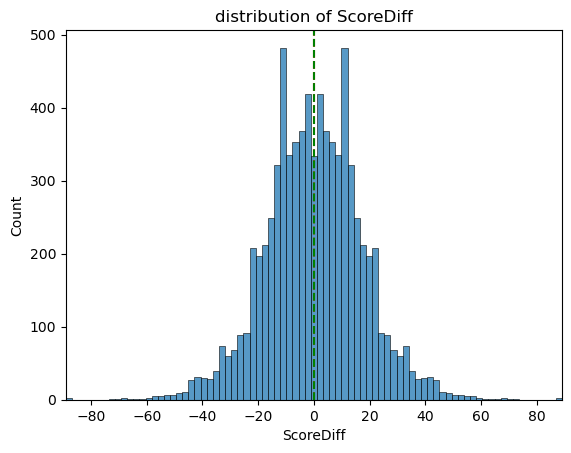

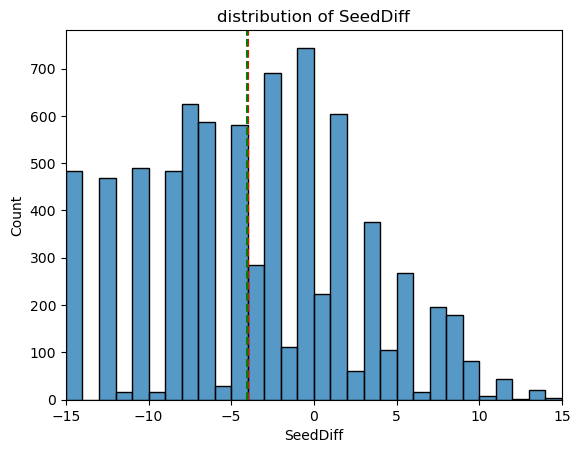

In [37]:
columns = ["ScoreDiff", "SeedDiff"]

for column in columns:
    
    median = df[column].median()
    mean = df[column].mean()
    
    sns.histplot(x=df[column])
    
    plt.axvline(median, color='red', linestyle='--', label='Median')
    plt.axvline(mean, color='green', linestyle='--', label='Mean')
    
    plt.title(f"distribution of {column}")
    plt.xlim(df[column].min(), df[column].max())
    plt.show()